# 11  THE MOMENTUM EFFECT
>Jegadeesh and Titman (1993): Stocks that have performed well in the medium-term past (six to 12 months) are more likely to outperform in the future.

### Explanations
* behavioral phenomenon: investors’ delayed reaction and overreaction to information
* rational explanations: a manifestation of cross-sectionally persistent expected stock returns

### Content
* Measurement of momentum
* Examinations of the relation between momentum and future stock returns
* Momentum factor of Carhart (1997)

## 11.1 MEASURING MOMENTUM

* The most commonly used: 11-month return of the stock during the period beginning 12 months prior to and ending one month prior to the measurement date (minimum of 9). Excluding month t from the calculation of Mom removes the mechanical correlation between the measures of momentum and reversal.

$$Mom_{i,t}=100\left [ \prod_{m\in \left \{ t-11:t-1 \right \}} \left ( R_{i,m}+1 \right )-1\right ]$$

* Jegadeesh and Titman (1993): $R^{12M}$, $R^{9M}$, $R^{6M}$, $R^{3M}$ are the return of the given stock during the 12-, nine-, six-, and three-month periods, respectively, up to and including month t (minimum of 10, 7, 5, 3).
* Two less frequently used measures
    * $R^{t-12:t-1}$: 12-month return during months t − 12 through t − 1  (minimum of 10)
    * $R^{t-6:t-1}$: 6-month return during months t − 6 through t − 1  (minimum of 5)

In [1]:
import os 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import openpyxl  # 用于向excel中写入数据
import gc
from datetime import *
from EAP import *
File = os.path.join('结果', 'results_drop.xlsx')

In [8]:
# 原始数据pivot处理
raw_data = pd.read_csv(os.path.join('原始数据', 'TRD_Mnth.csv'))
raw_data['Trdmnt'] = pd.to_datetime(raw_data['Trdmnt'])
RET = raw_data.pivot(index='Stkcd', columns='Trdmnt', values='Mretwd')  # 月度收益
RET.to_csv('RET.csv')
MktCap = raw_data.pivot(index='Stkcd', columns='Trdmnt', values='Msmvosd')  # 月度市值
MktCap.to_csv('MktCap.csv')

In [6]:
# 剔除代码标签
filter = pd.read_csv('30+IPO.csv', index_col=0)
RET = pd.read_csv('RET.csv', index_col=0)
MktCap = pd.read_csv('MktCap.csv', index_col=0).loc[:, '2000-01-01':]  # 市值只需要2000年1月开始的
filter.columns = MktCap.columns
filter = filter.astype(bool)
# 市值剔除
MktCap = MktCap[filter]
# 将无风险利率处理成月度
Rfree = pd.read_csv(os.path.join('原始数据', 'TRD_Nrrate.csv'), index_col=0)
Rfree = pd.concat(
    [pd.DataFrame([], index=MktCap.columns), Rfree],
    axis=1,
    join='inner'
).iloc[:, 0]
RET.head()

,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,1998-06-01,1998-07-01,1998-08-01,1998-09-01,1998-10-01,...,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
Stkcd,,,,,,,,,,,,,,,,,,,,,
1,0.021145,-0.020276,-0.050198,-0.032916,-0.037872,-0.146986,0.008178,-0.064890,-0.022924,-0.055802,...,0.037217,0.080343,-0.120578,0.143633,0.025399,0.002123,0.100989,0.042976,-0.059656,0.075867
2,-0.071580,-0.056489,0.087379,0.046875,-0.047619,-0.132090,0.065083,-0.154537,0.013815,-0.085954,...,0.097535,-0.059896,-0.075485,0.041573,0.034160,-0.067328,0.003876,0.024324,0.044101,0.161733
3,0.022659,-0.010340,0.047761,0.009972,0.021157,-0.147790,0.006483,-0.217391,0.028807,-0.058000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.128378,-0.059880,0.082803,0.164706,0.203283,-0.206716,0.005291,-0.078947,0.367143,0.338558,...,0.114139,0.166590,-0.149525,-0.013023,-0.128181,0.072432,-0.052419,-0.032447,0.094557,0.134606
5,-0.102198,0.183599,0.127198,0.161468,-0.036335,-0.136066,-0.045541,0.021371,0.008759,-0.033285,...,0.095930,-0.124668,-0.081818,0.003300,-0.039474,0.061644,0.025806,-0.050314,-0.029801,0.054608


In [20]:
def Momentum(ret, num, including, minimum):
    '''
    对于一只股票历史所有收益率序列计算动量

    Parameters
    ----------
    ret: 个股历史收益率序列  (pd.Series)
    num: 采用几个月长度计算  (int)
    including: 是否包含当月的收益  (bool)
    minimum: 最少需要几个月有数值  (int)

    Returns
    -------
    动量序列  (pd.Series)
    '''
    if including:
        m = ret.rolling(window=num).apply(
            lambda x: np.nan if pd.Series(x).notna().sum() < minimum else 100 * ((pd.Series(x).dropna() + 1).cumprod().iloc[-1] - 1)
        )
    else:
        m = ret.rolling(window=num+1).apply(
            lambda x: np.nan if pd.Series(x[:-1]).notna().sum() < minimum else 100 * ((pd.Series(x[:-1]).dropna() + 1).cumprod().iloc[-1] - 1)
        )
    
    return m

In [21]:
start = '2000-01-01'
# 按顺序计算动量
RET.apply(Momentum, num=11, including=False, minimum=9, axis=1).loc[:, start:].to_csv('Mom.csv')
[RET.apply(Momentum, num=i, including=True, minimum=j, axis=1).loc[:, start:].to_csv('R_M' + str(i) + '.csv') for i, j in zip([12, 9, 6, 3], [10, 7, 5, 3])]
[RET.apply(Momentum, num=i, including=False, minimum=j, axis=1).loc[:, start:].to_csv('R_t' + str(i) + '.csv') for i,j in zip([12, 6], [10, 5])]

[None, None]

In [3]:
# 读取动量数据
Mom = pd.read_csv('Mom.csv', index_col=0)
R_XM = [pd.read_csv('R_M' + str(i) + '.csv', index_col=0) for i in [12, 9, 6, 3]]
R_tX = [pd.read_csv('R_t' + str(i) + '.csv', index_col=0) for i in [12, 6]]
# 剔除股票
Mom = Mom[filter]
R_XM = [x[filter] for x in R_XM]
R_tX = [x[filter] for x in R_tX]
all_mom = [Mom] + R_tX + R_XM

In [28]:
Mom.head()

,2000-01-01,2000-02-01,2000-03-01,2000-04-01,2000-05-01,2000-06-01,2000-07-01,2000-08-01,2000-09-01,2000-10-01,...,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
Stkcd,,,,,,,,,,,,,,,,,,,,,
1,23.936540,40.129044,37.529023,40.888787,5.598416,-32.829166,-15.690274,-22.827671,-21.674939,-21.408689,...,15.131213,19.966337,38.134751,36.045544,47.871004,40.999374,29.534521,44.446216,58.651896,64.774171
2,37.668005,63.388236,124.985595,66.045582,31.944645,-0.827395,24.371873,30.309038,33.460711,37.842365,...,-12.604888,12.434864,17.307321,12.816926,23.956914,19.584097,10.385284,11.133313,8.422135,20.902617
3,26.327710,44.360581,48.314263,82.863492,58.236293,0.655493,1.636484,8.386942,23.170577,27.992093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.449552,84.944933,33.893389,109.673360,127.071318,159.209204,150.806702,182.033044,254.967141,282.742600,...,-14.879663,3.932815,12.106388,9.693827,15.703393,6.444240,24.779836,20.978190,12.145546,24.204625
5,10.218913,60.818680,54.316467,40.093488,24.217596,24.377939,28.341424,20.772833,30.564941,19.729738,...,-10.880908,5.307162,-4.069825,2.364837,-3.492104,-1.351474,5.442088,16.483421,0.666642,9.328409


## 11.2 SUMMARY STATISTICS

**Table 11.1**: The table presents the time-series means for each cross-sectional value.

In [8]:
summa = Summary(all_mom)
summa.index = ['Mom', 'R_t12', 'R_t6', 'R_12M', 'R_9M', 'R_6M', 'R_3M']
summa

,mean,std,Skew,Kurt,min,5%,25%,50%,75%,95%,max,count
Mom,22.20,42.39,2.38,20.62,-59.34,-25.40,-4.88,13.25,39.15,98.47,386.26,1175.0
R_t12,24.68,45.07,2.33,18.17,-60.18,-25.68,-4.19,14.99,42.67,106.31,406.76,1159.0
R_t6,10.74,28.58,2.47,26.99,-52.84,-21.90,-6.91,5.33,22.21,60.59,273.94,1262.0
R_12M,25.01,45.24,2.32,18.02,-60.36,-25.61,-4.00,15.30,43.14,106.87,406.13,1175.0
R_9M,17.61,36.91,2.32,19.87,-57.42,-24.36,-5.82,10.14,32.47,83.78,335.04,1227.0
R_6M,11.07,28.80,2.47,26.91,-52.83,-21.81,-6.76,5.59,22.62,61.39,276.28,1280.0
R_3M,5.46,19.66,2.63,38.13,-46.11,-17.45,-6.35,2.19,13.53,38.50,209.43,1314.0


## 11.3 CORRELATIONS
Table 11.2 presents average cross-sectional correlations between the measures of momentum and the variables examined in previous chapters of this book.

In [4]:
# 读取bm和beta
bm = pd.read_csv('bm.csv', index_col=0)
bm = bm.iloc[:, (len(bm.columns) - 240):]  # 截取日期
bm = fill_code(RET, bm)  # 补齐股票代码
bm.columns = Mom.columns
bm = bm[filter]  # 剔除股票
beta = pd.read_csv('beta.csv', index_col=0)
beta = beta.iloc[:, (len(beta.columns) - 240):]
beta = fill_code(RET, beta)
beta.columns = Mom.columns
beta = beta[filter]  # 剔除股票
# 市值单位化为百万元
MktCap = MktCap / 1000
size = np.log(MktCap)

In [17]:
# 计算相关系数
ExcelWrite1(
    Corr(all_mom, [beta, size, bm], kind='pearson'),
    row=12,
    col=6,
    file_name=File,
    sheet_name='Table 11_2'
)
ExcelWrite1(
    Corr(all_mom, [beta, size, bm], kind='spearman'),
    row=17,
    col=6,
    file_name=File,
    sheet_name='Table 11_2'
)

![Table11_2.png](https://i.loli.net/2020/04/22/458WQKuGoBHiySC.png)

## 11.4 MOMENTUM AND STOCK RETURNS

### 11.4.1 Univariate Portfolio Analysis

**Panel A** presents the equal-weighted average values of Mom, 𝛽, MktCap, and BM for each of the portfolios formed by sorting on Mom.

In [21]:
ExcelWrite1(
    PortChar(Mom, [Mom, beta, MktCap, bm]),
    row=7,
    col=5,
    file_name=File,
    sheet_name='Table 11_3'
)

![Table113_A.png](https://i.loli.net/2020/04/22/vfXo78zqN3Pha6B.png)

**Panel B (Panel C)** shows the average value-weighted (equal-weighted) one-month-ahead excess return (in percent per month) for each of the 10 decile portfolios. 

In [7]:
RET = RET.loc[:, '2000-01-01':] * 100  # 截取收益
RET = RET[filter]  # 剔除股票
# 读取因子收益
f = pd.read_csv(os.path.join('原始数据', 'STK_MKT_ThrfacMonth.csv'), index_col=0) * 100
f.index = RET.columns

In [15]:
# 市值加权结果
Table113_VW = UniPortR(all_mom, f, Rfree, **{'Ret': RET.shift(periods=-1, axis=1), 'method': 'VW', 'cap': MktCap})
ExcelWrite2(
    Table113_VW[0].round(2),
    Table113_VW[1].round(2),
    row=13,
    col=4,
    file_name=File,
    sheet_name='Table 11_3'
)

In [16]:
# 等权结果
Table113_EW = UniPortR(all_mom, f, Rfree, **{'Ret': RET.shift(periods=-1, axis=1), 'method': 'EW'})
ExcelWrite2(
    Table113_EW[0].round(2),
    Table113_EW[1].round(2),
    row=29,
    col=4,
    file_name=File,
    sheet_name='Table 11_3'
)

![Table113_BC.png](https://i.loli.net/2020/04/22/HdxfckhMCyRW4nE.png)

**Tabel 11.4** Univariate Portfolio Analysis—k-Month-Ahead Returns  

This table presents the results of univariate portfolio analyses of the relation between each of measures of momentum and future stock returns.  
Each panel in the table shows that average k-month-ahead return (as indicated in the column header), in percent per month, along with the associated FF alpha, of the portfolio, that is, long the 10th decile portfolio and short the first decile portfolio. 

In [6]:
# 市值加权的结果
Table114_VW = UnikAhead(all_mom, f, Rfree, RET, **{'method': 'VW', 'cap': MktCap})

In [8]:
ExcelWrite3(
    [Table114_VW[0].round(2), Table114_VW[2].round(2)],
    [Table114_VW[1].round(2), Table114_VW[3].round(2)],
    row=5,
    col=5,
    file_name=File,
    sheet_name='Table 11_4'
)

![Table114_A.png](https://i.loli.net/2020/04/22/jY85kOfTGt6hw7P.png)

In [11]:
# 等权的结果
Table114_EW = UnikAhead(all_mom, f, Rfree, RET, **{'method': 'EW'})

In [13]:
ExcelWrite3(
    [Table114_EW[0].round(2), Table114_EW[2].round(2)],
    [Table114_EW[1].round(2), Table114_EW[3].round(2)],
    row=35,
    col=5,
    file_name=File,
    sheet_name='Table 11_4'
)

![Table114_C.png](https://i.loli.net/2020/04/22/P1s3TAdSFuNEtpI.png)

### 11.4.2 Bivariate Dependent-Sort Portfolio Analysis
**Bivariate Dependent-Sort Portfolio Analysis—Control for MktCap**

In [20]:
# 市值加权的结果
Table115VW = BiDep_all(MktCap, Mom, RET.shift(periods=-1, axis=1), Rfree, f=f, method='VW', q=(5, 5), cap=MktCap)
# 等权结果
Table115EW = BiDep_all(MktCap, Mom, RET.shift(periods=-1, axis=1), Rfree, f=f, method='EW', q=(5, 5))

In [21]:
ExcelWrite1(
    Table115VW,
    row=9,
    col=5,
    file_name=File,
    sheet_name='Table 11_5'
)
ExcelWrite1(
    Table115EW,
    row=9+len(Table115VW)+2,
    col=5,
    file_name=File,
    sheet_name='Table 11_5'
)

![Table115.png](https://i.loli.net/2020/04/22/2SIhE6VwxD57ndm.png)

**Bivariate Dependent-Sort Portfolio Analysis**

In [23]:
Table117 = pd.concat(
    [
        BiDep_ls(i, Mom, RET.shift(periods=-1, axis=1), Rfree, f=f, method=j, q=(5, 5), cap=MktCap) for i, j in zip([beta, beta, bm, bm], ['VW', 'EW', 'VW', 'EW'])
    ],
    axis=0
)

In [24]:
ExcelWrite1(
    Table117,
    row=7,
    col=5,
    file_name=File,
    sheet_name='Table 11_7'
)

![Table117.png](https://i.loli.net/2020/04/22/JLPgSDjkafzqT82.png)

**Bivariate Independent-Sort Portfolio Analysis**

In [25]:
Table118 = pd.concat(
    [
        BiInd(i, Mom, RET.shift(periods=-1, axis=1), Rfree, f=f, method=j, cap=MktCap) for i, j in zip([beta, beta, MktCap, MktCap, bm, bm], ['VW', 'EW'] * 3)
    ],
    axis=0
)

In [26]:
ExcelWrite1(
    Table118,
    row=6,
    col=5,
    file_name=File,
    sheet_name='Table 11_8'
)

![Table118.png](https://i.loli.net/2020/04/22/cupDKBEwMGqboTQ.png)

**Bivariate Dependent-Sort Portfolio Analysis—Control for Mom**

In [27]:
Table119 = pd.concat(
    [
        BiDep_ls(Mom, i, RET.shift(periods=-1, axis=1), Rfree, f=f, method=j, cap=MktCap) for i, j in zip([beta, beta, MktCap, MktCap, bm, bm], ['VW', 'EW'] * 3)
    ],
    axis=0
)

In [28]:
ExcelWrite1(
    Table119,
    row=6,
    col=5,
    file_name=File,
    sheet_name='Table 11_9'
)

![Table119.png](https://i.loli.net/2020/04/22/eMxHqrYF5SAtfic.png)

**Bivariate Independent-Sort Portfolio Analysis—Control for Mom**

In [29]:
Table1110 = pd.concat(
    [
        BiInd(Mom, i, RET.shift(periods=-1, axis=1), Rfree, f=f, method=j, cap=MktCap) for i, j in zip([beta, beta, MktCap, MktCap, bm, bm], ['VW', 'EW'] * 3)
    ],
    axis=0
)

In [30]:
ExcelWrite1(
    Table1110,
    row=6,
    col=5,
    file_name=File,
    sheet_name='Table 11_10'
)

![Table1110.png](https://i.loli.net/2020/04/22/qOlreA3KYG1wIWi.png)

### 11.4.3 Fama–MacBeth Regression Analysis 

In [18]:
Spe = [
    [Mom], [Mom, beta], [Mom, size], [Mom, bm],
    [Mom, beta, size], [Mom, beta, bm], [Mom, size, bm], [Mom, beta, size, bm]
]
Pos = [[2], [4], [2, 6], [2], [6], [4], [2], []]
Num = [[6], [4], [2, 2], [4], [2], [2], [2], []]
Table1111 = pd.DataFrame(
    [FMRegression(RET.shift(periods=-1, axis=1), Rfree, i, pos=j, num=k, level=0.005) for i, j, k in zip(Spe, Pos, Num)]
).T

In [19]:
ExcelWrite1(
    Table1111,
    row=10,
    col=5,
    file_name=File,
    sheet_name='Table 11_11'
)

![Table1111.png](https://i.loli.net/2020/04/22/eOHWcpQLEfgjloI.png)

## 11.5 THE MOMENTUM FACTOR

>The monthly momentum factor most commonly used in empirical asset pricing is created by sorting all stocks into two groups based on market capitalization calculated at the end of the most recent June and three groups based on momentum.  
The monthly return of the momentum factor is then taken to be the average one-month-ahead return of the two U portfolios minus the average one-month-ahead return of the two D portfolios.

In [8]:
def MOM():
    '''
    构造动量因子

    Returns
    -------
    动量因子月度收益  (pd.Series)
    '''
    ret = RET.shift(periods=-1, axis=1).dropna(how='all', axis=1)
    date_ = pd.to_datetime(Mom.columns[:-1])
    lsret = []
    for i in date_:
        if (i.month >= 1) & (i.month <= 5):  # 1-5月用前一年6月的市值
            if i.year >= 2001:
                j = datetime.strftime(i, '%Y-%m-%d')
                k = datetime.strftime(datetime(i.year-1, 6, 1), '%Y-%m-%d')
            else:
                j = datetime.strftime(i, '%Y-%m-%d')
                k = j
        else:  # 用当年6月的市值
            j = datetime.strftime(i, '%Y-%m-%d')
            k = datetime.strftime(datetime(i.year, 6, 1), '%Y-%m-%d')
        temp = pd.concat([ret[j], Mom[j], MktCap[k]], axis=1, keys=['r', 'm', 'cap']).dropna()
        temp['mg'] = pd.qcut(temp['m'], q=3, labels=False)  # 动量分组
        temp['cg'] = pd.qcut(temp['cap'], q=2, labels=False)  # 市值分组
        US = temp[(temp['mg'] == 2) & (temp['cg'] == 0)]
        UL = temp[(temp['mg'] == 2) & (temp['cg'] == 1)]
        DS = temp[(temp['mg'] == 0) & (temp['cg'] == 0)]
        DL = temp[(temp['mg'] == 0) & (temp['cg'] == 1)]
        lsret.append(
            (US['r'].mean() + UL['r'].mean()) / 2 - (DS['r'].mean() + DL['r'].mean()) / 2
        )
    lsret = pd.Series(lsret, index=Mom.columns[(len(Mom.columns)-len(lsret)):])

    return lsret

In [9]:
MOM_factor = MOM()
MOM_factor.to_csv('MOM_factor.csv')

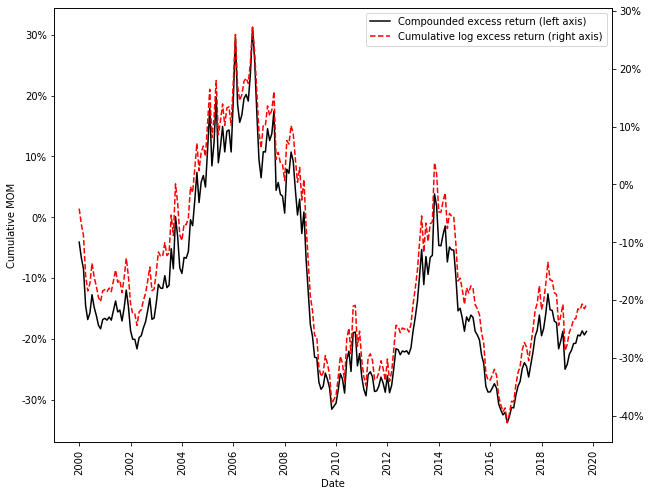

In [14]:
MOM_factor = pd.read_csv('MOM_factor.csv', index_col=0) / 100
plot_Cum_Ret(MOM_factor.iloc[:, 0], 'Cumulative MOM')